# Train
https://mapreader.readthedocs.io/en/latest/User-guide/Train.html

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Read annotations

In [2]:
from mapreader import loadAnnotations

In [3]:
annotated_images = loadAnnotations()

annotated_images.load("./annotations_phenotype_open_access/phenotype_test_#kasra#.csv", 
                      path2dir="./dataset/open_access_plant/slice_50_50/")

* reading: ./annotations_phenotype_open_access/phenotype_test_#kasra#.csv
* #rows: 124
* label column name: label (you can change this later by .set_col_label(new_label) )
* shuffle rows: Yes
* update paths in 'image_id' column by inserting './dataset/open_access_plant/slice_50_50/'

------------------------
* Number of annotations: 124

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/worked_examples/non...      1
1  /Users/rwood/LwM/MapReader/worked_examples/non...      1
2  /Users/rwood/LwM/MapReader/worked_examples/non...      2
3  /Users/rwood/LwM/MapReader/worked_examples/non...      1
4  /Users/rwood/LwM/MapReader/worked_examples/non...      1
...

* Value counts (column: label):
1    86
2    38
Name: label, dtype: int64
------------------------



In [4]:
annotated_images.annotations

,image_id,label
0,/Users/rwood/LwM/MapReader/worked_examples/non...,1
1,/Users/rwood/LwM/MapReader/worked_examples/non...,1
2,/Users/rwood/LwM/MapReader/worked_examples/non...,2
3,/Users/rwood/LwM/MapReader/worked_examples/non...,1
4,/Users/rwood/LwM/MapReader/worked_examples/non...,1
...,...,...
119,/Users/rwood/LwM/MapReader/worked_examples/non...,2
120,/Users/rwood/LwM/MapReader/worked_examples/non...,2
121,/Users/rwood/LwM/MapReader/worked_examples/non...,1
122,/Users/rwood/LwM/MapReader/worked_examples/non...,1


In [5]:
print(annotated_images)

------------------------
* Number of annotations: 124

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/worked_examples/non...      1
1  /Users/rwood/LwM/MapReader/worked_examples/non...      1
2  /Users/rwood/LwM/MapReader/worked_examples/non...      2
3  /Users/rwood/LwM/MapReader/worked_examples/non...      1
4  /Users/rwood/LwM/MapReader/worked_examples/non...      1
...

* Value counts (column: label):
1    86
2    38
Name: label, dtype: int64
------------------------



In [6]:
# Shift labels so that they start from 0
annotated_images.adjust_labels(shiftby=-1)

--------------------
[INFO] value counts before shift:
1    86
2    38
Name: label, dtype: int64
--------------------
[INFO] value counts after shift:
0    86
1    38
Name: label, dtype: int64
--------------------


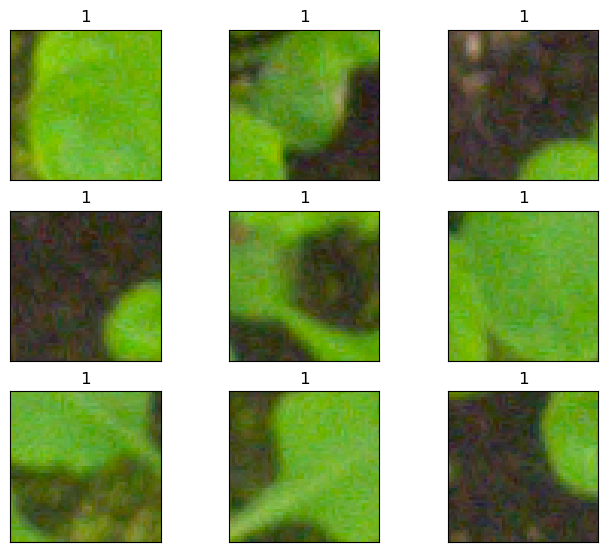

In [7]:
# show sample images for target label (tar_label)
annotated_images.show_image_labels(tar_label=1, num_sample=9)

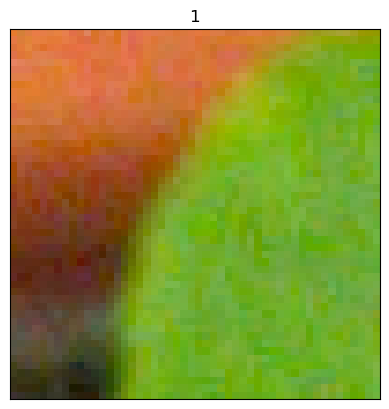

In [8]:
# show an image based on its index 
annotated_images.show_image(indx=50)

## Split annotations into train/val

In [9]:
annotated_images.split_annotations(frac_train=0.8, 
                                   frac_val=0.2, 
                                   frac_test=0.0)

---------------------
* Split dataset into:
    Train: 99
    Valid: 25
    Test : 0
---------------------


In [10]:
annotated_images.train.head()

,image_id,label
48,/Users/rwood/LwM/MapReader/worked_examples/non...,0
65,/Users/rwood/LwM/MapReader/worked_examples/non...,0
41,/Users/rwood/LwM/MapReader/worked_examples/non...,1
5,/Users/rwood/LwM/MapReader/worked_examples/non...,0
21,/Users/rwood/LwM/MapReader/worked_examples/non...,1


In [11]:
annotated_images.train["label"].value_counts()

0    69
1    30
Name: label, dtype: int64

In [12]:
annotated_images.val["label"].value_counts()

0    17
1     8
Name: label, dtype: int64

## Prepare datasets

In [13]:
import numpy as np
from torchvision import transforms
from mapreader import patchTorchDataset
import torch

In [49]:
resize = (224,224)
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([transforms.Resize(resize), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(normalize_mean,normalize_std)])


In [50]:
train_dataset = patchTorchDataset(annotated_images.train, transform=data_transforms)
val_dataset = patchTorchDataset(annotated_images.val, transform=data_transforms)

In [51]:
train_dataset.patchframe

,image_id,label
48,/Users/rwood/LwM/MapReader/worked_examples/non...,0
65,/Users/rwood/LwM/MapReader/worked_examples/non...,0
41,/Users/rwood/LwM/MapReader/worked_examples/non...,1
5,/Users/rwood/LwM/MapReader/worked_examples/non...,0
21,/Users/rwood/LwM/MapReader/worked_examples/non...,1
...,...,...
70,/Users/rwood/LwM/MapReader/worked_examples/non...,0
103,/Users/rwood/LwM/MapReader/worked_examples/non...,0
115,/Users/rwood/LwM/MapReader/worked_examples/non...,1
119,/Users/rwood/LwM/MapReader/worked_examples/non...,1


In [52]:
train_count_list=train_dataset.patchframe["label"].value_counts().to_list()
val_count_list=val_dataset.patchframe["label"].value_counts().to_list()

weights = np.reciprocal(torch.Tensor(train_count_list))
weights = weights.double()

In [53]:
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[train_dataset.patchframe["label"].to_list()], 
    num_samples=len(train_dataset))

valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[val_dataset.patchframe["label"].to_list()], 
    num_samples=len(val_dataset))

## Set up `classifier`

### Load datasets

In [54]:
from mapreader import classifier

In [55]:
my_classifier = classifier()

[INFO] Device is set to cpu


In [56]:
batch_size = 8

# Add training dataset
my_classifier.add2dataloader(train_dataset, 
                            set_name="train", 
                            batch_size=batch_size, 
                            shuffle=False,
                            sampler=train_sampler
                           )

# Add validation dataset
my_classifier.add2dataloader(val_dataset, 
                            set_name="val", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            sampler=valid_sampler
                           )

[INFO] added 'train' dataloader with 99 elements.
[INFO] added 'val' dataloader with 25 elements.


In [57]:
my_classifier.dataset_sizes

{'train': 99, 'val': 25}

In [58]:
my_classifier.print_classes_dl('train')

[INFO] labels:      [0, 1]


In [59]:
class_names = {0: "No", 1: "Plant"}
my_classifier.set_classnames(class_names)

my_classifier.print_classes_dl('train')

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'Plant'}


[INFO] dataset: train
#samples:    99
#batch size: 8
#batches:    13


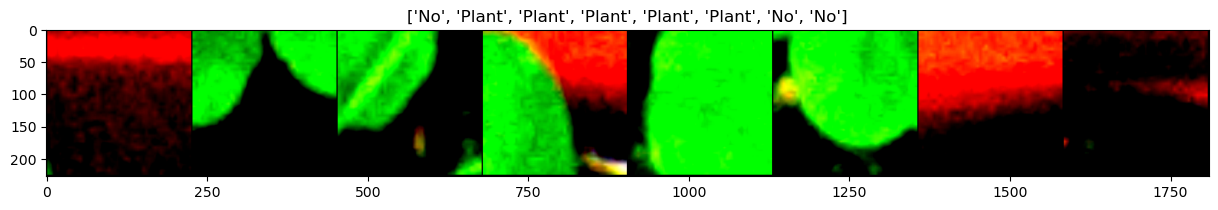

In [60]:
my_classifier.show_sample(set_name='train', batch_number=1)

### Load a (pretrained) PyTorch model

In [61]:
my_classifier.initialize_model("resnet18")

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'Plant'}


In [62]:
my_classifier.model_summary()

------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn2.weight |                   64 |                 [64] |
|

### Set up optimisier, scheduler and criterion

In [63]:
params_to_optimise = my_classifier.layerwise_lr(min_lr=1e-4, max_lr=1e-3)

In [64]:
my_classifier.initialize_optimizer(params2optim=params_to_optimise)

In [65]:
my_classifier.initialize_scheduler()

In [66]:
criterion = torch.nn.CrossEntropyLoss()

my_classifier.add_criterion(criterion)

## Train/fine-tune model

**Note:** it is possible to interrupt a training (using Kernel/Interrupt in Jupyter Notebook or ctrl+C). 

In [67]:
my_classifier.train(num_epochs=10, 
                   save_model_dir="./models_plant_open", 
                   tensorboard_path="tboard_plant_open", 
                   verbosity_level=0,
                   tmp_file_save_freq=2,
                   remove_after_load=False,
                   print_info_batch_freq=5)

2023-03-08 14:09:02 JY5FK6W3K5 [INFO] train    -- 1/10 --        8/99 (  8.1%) -- Loss: 1.207
2023-03-08 14:09:03 JY5FK6W3K5 [INFO] train    -- 1/10 --       48/99 ( 48.5%) -- Loss: 0.426
2023-03-08 14:09:04 JY5FK6W3K5 [INFO] train    -- 1/10 --       88/99 ( 88.9%) -- Loss: 2.743
2023-03-08 14:09:04 JY5FK6W3K5 [INFO] train    -- 1/10 -- Loss: 0.541; F_macro: 83.84; R_macro: 83.86
2023-03-08 14:09:04 JY5FK6W3K5 [INFO] val      -- 1/10 --        8/25 ( 32.0%) -- Loss: 0.072
2023-03-08 14:09:05 JY5FK6W3K5 [INFO] val      -- 1/10 -- Loss: 0.047; F_macro: 100.00; R_macro: 100.00

2023-03-08 14:09:05 JY5FK6W3K5 [INFO] train    -- 2/10 --        8/99 (  8.1%) -- Loss: 0.416
2023-03-08 14:09:06 JY5FK6W3K5 [INFO] train    -- 2/10 --       48/99 ( 48.5%) -- Loss: 0.097
2023-03-08 14:09:07 JY5FK6W3K5 [INFO] train    -- 2/10 --       88/99 ( 88.9%) -- Loss: 0.011
2023-03-08 14:09:08 JY5FK6W3K5 [INFO] train    -- 2/10 -- Loss: 0.305; F_macro: 92.86; R_macro: 92.95
2023-03-08 14:09:08 JY5FK6W3K5 [I

2023-03-08 14:09:35 JY5FK6W3K5 [INFO] train    -- 10/10 --       48/99 ( 48.5%) -- Loss: 0.087
2023-03-08 14:09:37 JY5FK6W3K5 [INFO] train    -- 10/10 --       88/99 ( 88.9%) -- Loss: 0.252
2023-03-08 14:09:37 JY5FK6W3K5 [INFO] train    -- 10/10 -- Loss: 0.114; F_macro: 95.81; R_macro: 96.72
2023-03-08 14:09:37 JY5FK6W3K5 [INFO] val      -- 10/10 --        8/25 ( 32.0%) -- Loss: 1.725
2023-03-08 14:09:37 JY5FK6W3K5 [INFO] val      -- 10/10 -- Loss: 1.124; F_macro: 91.99; R_macro: 92.86

SAVE temp file: tmp_9564867482_checkpoint.pkl | set .last_epoch: 10
[INFO] SAVE temp file: tmp_9564867482_checkpoint.pkl | set .last_epoch: 10

Total time: 0m 36s
[INFO] Save model epoch: 7 with least valid loss: 0.0041
[INFO] Path: /Users/rwood/LwM/MapReader/worked_examples/non-geospatial/classification_plant_phenotype/models_plant_open/checkpoint_7.pkl


In [68]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

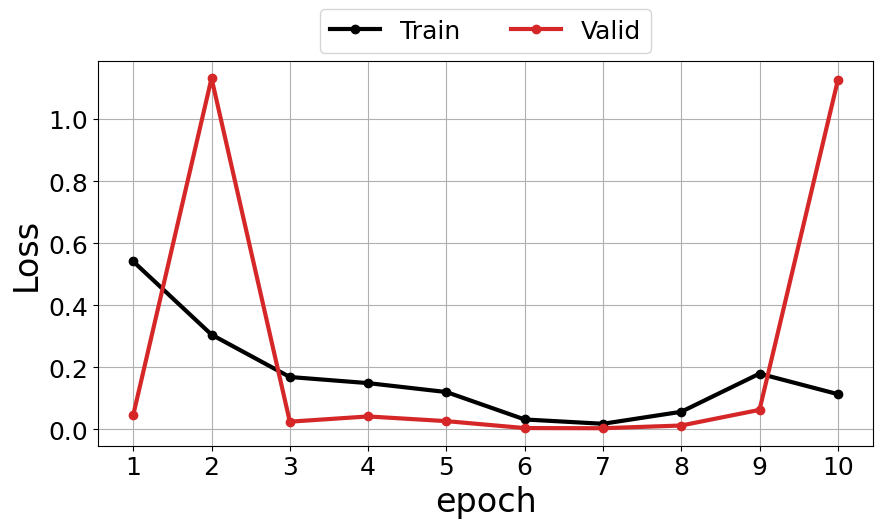

In [69]:
my_classifier.plot_metric(y_axis=["epoch_loss_train", "epoch_loss_val"],
                         y_label="Loss",
                         legends=["Train", "Valid"])

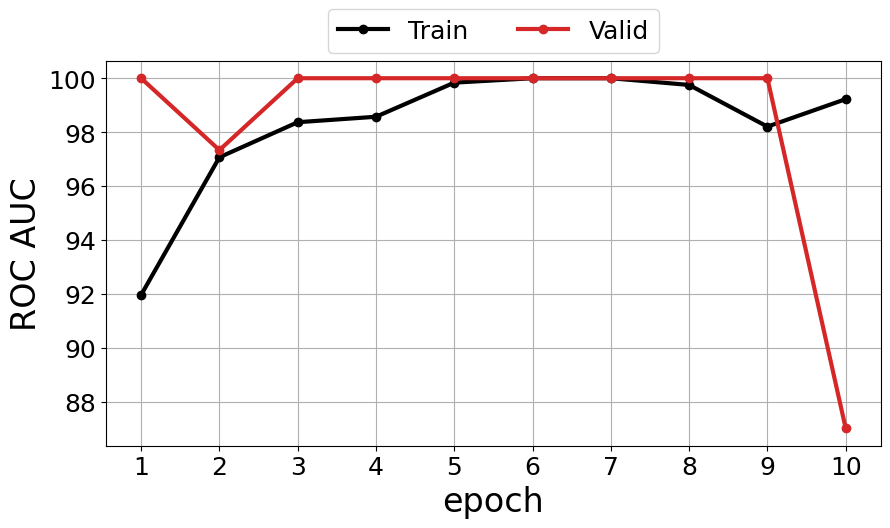

In [70]:
my_classifier.plot_metric(y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
                         y_label="ROC AUC",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

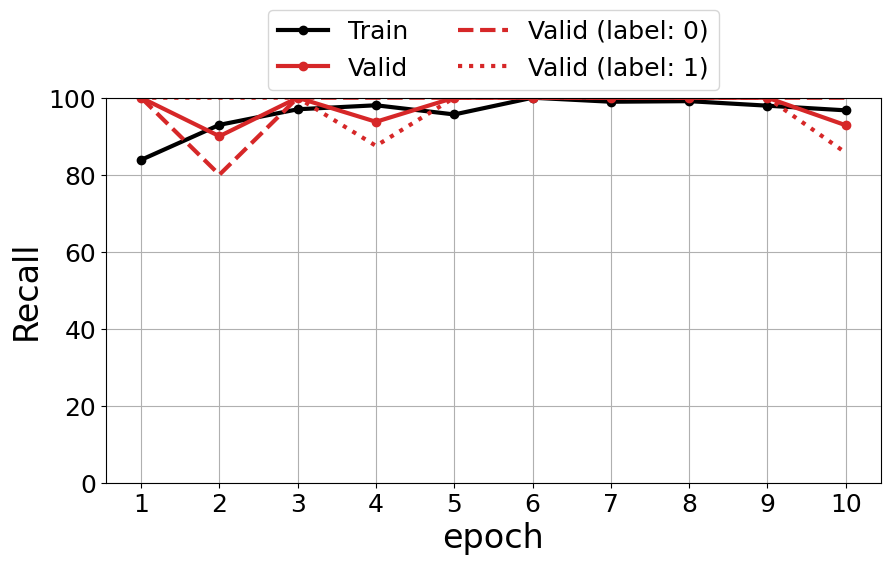

In [71]:
my_classifier.plot_metric(y_axis=["epoch_recall_macro_train", 
                                 "epoch_recall_macro_val", 
                                 "epoch_recall_0_val", 
                                 "epoch_recall_1_val"],
                         y_label="Recall",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])